# Uvod
V sledečem notebooku se spopadam z analizo oglasov računalniških komponent s slovenskega bolšjega trga na spletni strani [Bolha](https://www.bolha.com/racunalnistvo). S spletne strani sem potegnil prvih 10000 oglasov urejenih po ceni (najdražji prvi). Žal zaradi napake pri delovanju spletne strani (bolha je zmožna prikazati samo prvih, glede na sortiranje, 10000 oglasov) nisem mogel dobiti večjega nabora podatkov. Vsak oglas je med podatki predstavljen z imenom, krajem objave, časom objave in ceno v evrih. Podatke sem iz bolhe zajel dne 2021-11-07.

Vsakemu izmed teh lastnosti je v sledeči analizi namenjen svoj razdelek s svojimi vprašanji in svojim zaključkom, tem pa je na začetku dodan še dodaten razdelek namenjen analizi ascii znakov v imenih oglasov. Pri zajemu podatkov sem namreč opazil veliko oglasov ki uporabljajo nenavadne ascii znake, kar je zajem podatkov dodatno otežilo.

## Večji cilji analize
Večji, ne pa tudi vsi, cilji ki si jih pred začetkom analize zastavljam so naslednji:
- Kreacija algoritma ki iz imena oglasa izlušči tip artikla (npr. GPU, računalnik, CPU...)
- Kateri artikli so najdražji
- Določitev korelacije med starostjo artikla in ceno
- Iz katerih mest je na bolhi objavljenih največ oglasov
- Določitev najpopularnejšega tipa artikla za posamezno mesto

Tem ciljem pa dodajam naslednje hipoteze:
- Najdražji artikli bodo grafične kartice
- Starejši artikli bodo dražji od novejših
- Največ oglasov je na bolhi objavljenih iz Ljubljane
- Najštevilčnejši oglasi za Ljubljano so ali oglasi za grafične kartice ali oglasi za računalnike

Z zastavljenimi cilji lahko uvozimo potrebne knjižnice, naložimo podatke in se lotimo analize

In [394]:
import pandas as pd
from collections import Counter
import string
import datetime
import dateutil

In [395]:
data = pd.read_csv("data.csv", sep=";;;", engine="python")
data['Date'] =  pd.to_datetime(data['Date'], format='%Y-%m-%dT%H:%M:%S%z')

# Analiza

## Nestandardni znaki v oglasih
Ker so me pri zajemu podatkov zelo mučili nestandardni znaki ki jih ljudje postavljajo v svoje oglase si najprej oglejmo te.

### Ciljna vprašanja:
1. Kakšen procent znakov uporabljenih v imenih oglasov ni alfanumeričnih?
2. Kateri so najpogosteje uporabljeni ne-alfanumerični znaki?
3. Ali se v tem primeru splača narediti analizo brez uporabe knjižnice `pandas`?

Najprej se lotimo analize brez knjižnice `pandas`

In [396]:
def is_alphanum(char):
    # Funkcija šteje šumnike kot nealfanumerične znake vendar to dopuščamo saj v naši analizi štejemo šumnike pod nenavadne znake
    return (char in string.ascii_letters or char in string.digits)

In [397]:
c = Counter()
for ime in data.Name.to_list():
    for char in ime:
        # Ignorirajmo dolgočasne alfanumerične znake
        if not is_alphanum(char):
            c[char] += 1

Seveda pa izkoristimo `pandas` za prikaz rezultatov

In [398]:
def df_of_counter(cnt, *args, **kwargs):
    # takes collections.Counter of and returns pandas.DataFrame where first column is the keys and second column is the values
    
    column_1 = list(cnt.keys())
    column_2 = list(cnt.values())


    return pd.DataFrame(list(zip(column_1, column_2)), *args, **kwargs)

In [399]:
df = df_of_counter(c, columns=['CHARACTER', 'FREQUENCY']).sort_values('FREQUENCY', ascending=False).reset_index(drop=True)
df

,CHARACTER,FREQUENCY
0,,60200
1,",",4581
2,-,3738
3,/,3730
4,č,2018
5,.,1350
6,(,1087
7,),1055
8,+,905
9,š,657


Opravimo prejšnjo analizo še s pomočjo knjižnice `pandas`

In [400]:
s = data["Name"].apply(lambda x : pd.Series(list(x))).stack().reset_index(level=0, drop=True)
frequency_by_char = s.groupby(s).size().sort_values(ascending=False).to_frame().rename(columns={0: 'FREQUENCY'})

frequency_by_char.index.names = ['CHARACTER']
frequency_by_char.head(10)

In [ ]:
n_of_chars = frequency_by_char.sum().FREQUENCY
percentage = frequency_by_char / n_of_chars
percentage = percentage.rename(columns={"FREQUENCY" : "PERCENTAGE"})

characters_df = pd.concat([frequency_by_char, percentage], axis=1)
characters_df.head(10)

,FREQUENCY,PERCENTAGE
CHARACTER,,
,60200,0.147152
i,18996,0.046433
a,17685,0.043229
n,17245,0.042153
o,15571,0.038061
e,15206,0.037169
r,12371,0.030239
0,12296,0.030056
l,8905,0.021767


Opazimo, da je v tem primeru analiza ***izključno*** s knjižnico `pandas` vzela ***več*** procesorskega časa in bila ***manj berljiva*** kot naivna analiza s `pythonom`.

S tabelo `characters_df` se zdaj lotimo še preostalih dveh vprašanj tega poglavja

In [ ]:
characters_df['ALFANUM'] = [is_alphanum(i) for i in characters_df.index.values]

alfanum = characters_df[characters_df.ALFANUM == True].drop(columns=["ALFANUM"])
not_alfanum = characters_df[characters_df.ALFANUM == False].drop(columns=["ALFANUM"])

In [ ]:
print(f"V imenih oglasov se pojavi {int(alfanum.sum().FREQUENCY)} alfanumeričnih znakov, kar je {alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")
print(f"V imenih oglasov se pojavi {int(not_alfanum.sum().FREQUENCY)} NE alfanumeričnih znakov, kar je {not_alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")

V imenih oglasov se pojavi 327126 alfanumeričnih znakov, kar je 0.7996 deleža vseh znakov.
V imenih oglasov se pojavi 81976 NE alfanumeričnih znakov, kar je 0.2004 deleža vseh znakov.


Presenetljivo je petina uporabljenih znakov ne-alfanumeričnih. Oglejmo si podrobneje te znake

In [ ]:
not_alfanum.head()

,FREQUENCY,PERCENTAGE
CHARACTER,,
,60200,0.147152
",",4581,0.011198
-,3738,0.009137
/,3730,0.009118
č,2018,0.004933


Vidimo, da na naš zaključek močno vpliva znak za presledek, ki, čeprav sicer ni alfanumerični, je popolnoma pričakovan v imenu oglasov. Kako bi statistika zgledala, če bi presledek šteli pod "običajne" oz. alfanumerične znake?

In [ ]:
alfanum = pd.concat([not_alfanum[not_alfanum.index == " "], alfanum]) # Ker je presledek najpogostejši znak bo to ohranilo urejenost
not_alfanum = not_alfanum.drop(" ")

In [ ]:
print(f"Zdaj se v imenih oglasov pojavi {int(alfanum.sum().FREQUENCY)} alfanumeričnih znakov, kar je {alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")
print(f"Zdaj se v imenih oglasov pojavi {int(not_alfanum.sum().FREQUENCY)} NE alfanumeričnih znakov, kar je {not_alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")

Zdaj se v imenih oglasov pojavi 387326 alfanumeričnih znakov, kar je 0.9468 deleža vseh znakov.
Zdaj se v imenih oglasov pojavi 21776 NE alfanumeričnih znakov, kar je 0.0532 deleža vseh znakov.


In [ ]:
not_alfanum.head(50)

,FREQUENCY,PERCENTAGE
CHARACTER,,
",",4581,0.011198
-,3738,0.009137
/,3730,0.009118
č,2018,0.004933
.,1350,0.003300
(,1087,0.002657
),1055,0.002579
+,905,0.002212
š,657,0.001606


### Zaključek
1. Kakšen procent znakov uporabljenih v imenih oglasov ni alfanumeričnih?

    V imenih oglasov je **20.04%** vseh uporabljnih znakov ne-alfanumeričnih. Če se omejimo na nenavadne znake in v analizi ne upoštevamo presledka je ne-alfanumeričnih znakov **5.32%**.

2. Kateri so najpogosteje uporabljeni ne-alfanumerični znaki?

    Najpogosteje uporabljeni ne-alfanumerični znaki (delež uporabe večji kot 0.002) so `,`, `-`, `/`, `č`, `.`, `(`, `)` in `+`.
    
3. Ali se v tem primeru splača narediti analizo brez uporabe knjižnice `pandas`?

    Videli smo da je samo štetje znakov veliko bolj berljivo in hitrejše narediti brez uporabe `pandas`, vendar je nadaljna analiza, kljub temu, da bi bila možna brez knjižnice `pandas` veliko bolj elegantna z njeno uporabo.

## Mesta prodaje
Sedaj si oglejmo oglase glede na mesta iz katerih so bili oddani in naredimo način da iz stolpca `CITY` v katerem so trenutno podatki oblike `mesto, ulica` izluščimo samo mesto.

### Ciljna vprašanja:
1. Iz katerih mest je oddanih največ oglasov?
2. Iz katerih mest je oddanih najmanj oglasov?
3. Iz katerega dela Ljubljane je oddanih največ oglasov?
4. Ali se v tem primeru splača narediti analizo s knjižnico `pandas`?

Zopet se najprej lotimo 4. točke

In [ ]:
def city_of_location_1(location):
    # V nadaljevanju bomo videli zakaj smo funkcijo poimenovali z _1

    if len(l := location.split(", ")) == 2:
        city, _ = l
    else:
        city = l[0]
    
    return city

In [ ]:
d = Counter()
for location in data.City.to_list():
    city = city_of_location_1(location)
    d[city] += 1

In [ ]:
df = df_of_counter(d, columns=["CITY", "N_OF_ADDS"]).sort_values('N_OF_ADDS', ascending=False).reset_index(drop=True)
df.head(10)

,CITY,N_OF_ADDS
0,Maribor,1303
1,Ljubljana Moste Polje,953
2,Ljubljana Bežigrad,505
3,Ljubljana Šiška,456
4,Nova Gorica,419
5,Ljubljana Center,367
6,Ljubljana Vič Rudnik,343
7,Domžale,273
8,Kranj,270
9,Celje,251


Vidimo da bi morali biti
- Ljubljana Moste Polje
- Ljubljana Bežigrad
- Ljubljana Šiška
- Ljubljana Center
- Ljubljana Vič Rudnik
- Ljubljana

združeni, zato malce modificirajmo našo funkcijo

In [ ]:
def city_of_location(location):
    LJUBLJANE = ["Ljubljana Moste Polje", "Ljubljana Bežigrad", "Ljubljana Šiška", "Ljubljana Center", "Ljubljana Vič Rudnik"]
    if len(l := location.split(", ")) == 2:
        city, _ = l

        # Če smo v enem izmed sekcij Ljubljane
        if city in LJUBLJANE:
            city = "Ljubljana"
    else:
        city = l[0]
    
    return city

In [ ]:
d = Counter()
for location in data.City.to_list():
    city = city_of_location(location)
    d[city] += 1

In [ ]:
df = df_of_counter(d, columns=["CITY", "N_OF_ADDS"]).sort_values('N_OF_ADDS', ascending=False).reset_index(drop=True)
df.head(10)

,CITY,N_OF_ADDS
0,Ljubljana,2836
1,Maribor,1303
2,Nova Gorica,419
3,Domžale,273
4,Kranj,270
5,Celje,251
6,Slovenska Bistrica,229
7,Koper,185
8,Škofljica,183
9,Slovenske Konjice,166


Kako težko pa bi se bilo tega problema lotiti s knjižnico `pandas`?

In [ ]:
data["Filtered_city"] = data["City"].map(city_of_location) # Ker v nadaljevanju želimo natančneje pogledati ljubljane ustvarimo nov stolpec za mesta

mesta = data.groupby("Filtered_city").size().to_frame(name="N_OF_ADDS").sort_values('N_OF_ADDS', ascending=False)
mesta.index.names = ['City']
mesta.head(10)

,N_OF_ADDS
City,
Ljubljana,2836
Maribor,1303
Nova Gorica,419
Domžale,273
Kranj,270
Celje,251
Slovenska Bistrica,229
Koper,185
Škofljica,183


In [ ]:
mesta['PERCENTAGE'] = mesta / len(data)
mesta.head(10)

,N_OF_ADDS,PERCENTAGE
City,,
Ljubljana,2836,0.284311
Maribor,1303,0.130627
Nova Gorica,419,0.042005
Domžale,273,0.027368
Kranj,270,0.027068
Celje,251,0.025163
Slovenska Bistrica,229,0.022957
Koper,185,0.018546
Škofljica,183,0.018346


Zaključimo, da je v tem primeru koda lepša in hitrejša s knjižnico `pandas`.

Oglejmo si zdaj mesta z največ

<AxesSubplot:xlabel='City'>

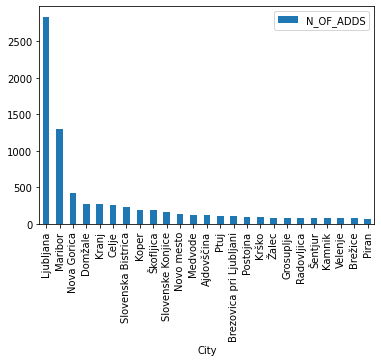

In [ ]:
mesta.reset_index().head(25).plot.bar(x='City', y='N_OF_ADDS')

in najmanj oglasov.

In [ ]:
mesta[mesta.N_OF_ADDS == 1]

,N_OF_ADDS,PERCENTAGE
City,,
Bistrica ob Sotli,1,0.0001
Gorenja vas - Poljane,1,0.0001
Hajdina,1,0.0001
Hodoš,1,0.0001
Bovec,1,0.0001
Kobilje,1,0.0001
Kontinentalna Hrvaška,1,0.0001
Rogašovci,1,0.0001
Poljska,1,0.0001


Kako pa zgleda število oglasov iz določenih regij ljubljane?

In [ ]:
def f(x):
    return pd.Series(x.split(", "))

ljubljane = data[data.Filtered_city == "Ljubljana"][["City"]]
ljubljane = ljubljane.City.apply(f).rename(columns={0 : "Ljubljana", 1 : "Sekcija"}).sort_values(['Ljubljana', 'Sekcija']).reset_index(drop=True)
ljubljane

,Ljubljana,Sekcija
0,Ljubljana,Brezje pri Lipoglavu
1,Ljubljana,Carinska pošta
2,Ljubljana,Dolenjska
3,Ljubljana,Dolenjska
4,Ljubljana,Dolenjska
...,...,...
2831,Ljubljana Šiška,Šiška
2832,Ljubljana Šiška,Šiška
2833,Ljubljana Šiška,Šiška
2834,Ljubljana Šiška,Šiška


In [ ]:
by_ljubljana = ljubljane.groupby("Ljubljana").size().sort_values(ascending=False).to_frame().rename(columns={0: "N_OF_ADDS"})
by_ljubljana['PERCENTAGE_OF_ALL'] = by_ljubljana / len(data)

by_ljubljana

,N_OF_ADDS,PERCENTAGE_OF_ALL
Ljubljana,,
Ljubljana Moste Polje,953,0.095539
Ljubljana Bežigrad,505,0.050627
Ljubljana Šiška,456,0.045714
Ljubljana Center,367,0.036792
Ljubljana Vič Rudnik,343,0.034386
Ljubljana,212,0.021253


<AxesSubplot:xlabel='Ljubljana'>

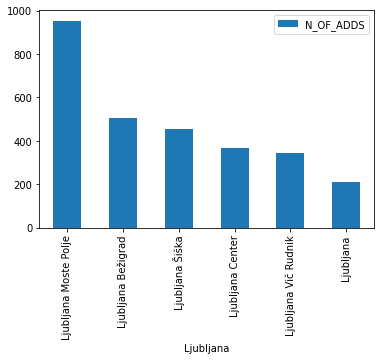

In [ ]:
by_ljubljana.plot.bar(y='N_OF_ADDS')

Največ oglasov je torej oddanih iz **Ljubljana Moste Polje**. Poglejmo si še natančneje to regijo.

In [ ]:
moste_polje = ljubljane[ljubljane.Ljubljana == "Ljubljana Moste Polje"].reset_index(drop=True)
moste_polje = moste_polje.groupby("Sekcija").size().sort_values(ascending=False).to_frame().rename(columns={0: "N_OF_ADDS"})
moste_polje['PERCENTAGE_OF_ALL'] = moste_polje / len(data)
moste_polje.head(10)

,N_OF_ADDS,PERCENTAGE_OF_ALL
Sekcija,,
BTC,371,0.037193
Jarše,139,0.013935
Moste,88,0.008822
Nove Fužine,77,0.007719
Nove Jarše,76,0.007619
Polje,48,0.004812
Dobrunje,45,0.004511
Štepanjsko naselje,26,0.002607
Zalog,18,0.001805


<AxesSubplot:xlabel='Sekcija'>

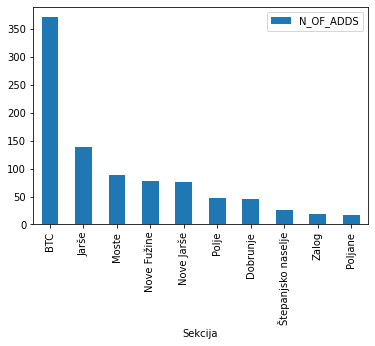

In [ ]:
moste_polje.head(10).plot.bar(y="N_OF_ADDS")

Preden zaključimo poglavje še popravimo tabelo `data`. V nadaljnji analizi nas namreč mesto ne bo zanimalo v tolikšne detajle kot nas je v tem poglavju.

In [ ]:
data = data.drop(columns=["City"]).rename(columns={"Filtered_city" : "City"})
data.head()

,Name,Date,Price,City
0,MINING RIG - Rudarjenje - Ethereum - 1.1GH/s -...,2021-10-16 12:40:29+02:00,28999,Ljubljana
1,Mining rig 18x rx5700xt,2021-11-02 20:28:51+01:00,18500,Ormož
2,Bitman Antminer S19 Pro 110 Th,2021-10-18 21:29:02+02:00,16300,Ljubljana
3,Mining rig RTX 3070 9 kom 570MH/s,2021-11-06 15:28:47+01:00,14000,Kungota
4,NOV mining Rig z 6 x Nvidia RTX3080Ti - 510 Mhs,2021-10-18 09:09:12+02:00,13590,Maribor


### Zaključek
1. Iz katerih mest je oddanih največ oglasov?

    Drastično največ oglasov je oddanih iz ***Ljubljane*** in ***Maribora***. Relativno veliko oglasov je oddanih tudi iz ***Nove Gorice***.

2. Iz katerih mest je oddanih najmanj oglasov?

    Samo en oglas je oddan iz 21 mest. Med njimi v oči bodeta ***Kontinentalna Hrvaška*** in ***Poljska***.

3. Iz katerega dela Ljubljane je oddanih največ oglasov?

    Največ oglasov je oddanih iz ***Ljubljana Moste Polje***, natančneje iz ***BTC***-ja.

4. Ali se v tem primeru splača narediti analizo s knjižnico `pandas`?

    Za kompleksno analizo ki smo jo delali v tem poglavju je bila knjižnica `pandas` nepogrešljiva in je propomogla k lepši in hitrejši kodi.

## Cena
V naslednjem poglavju si oglejmo nekaj statistik povezanih s ceno.

Opomnimo, da so tukaj podatki nekoliko pristranski, saj smo iz bolhe potegnili 10000 najdražjih oglasov.

### Ciljna vprašanja:
1. Kolikšna je cena najcenejšega in najdražjega oglasa?
2. Kolikšna je povprečna cena?
3. Katera mesta imajo v povprečju najdražje oglase?
4. Kakšna je zveza med ceno oglasa in datumom objave?

In [ ]:
print(f"Najdražji oglas stane {data['Price'].max()} EUR")
print(f"Najcenejši pa {data['Price'].min()} EUR")
print(f"Povprečna cena oglasa pa je {data['Price'].mean():.2f} EUR s standardno deviacijo {data['Price'].std(ddof=0):.2f} EUR")

Najdražji oglas stane 28999 EUR
Najcenejši pa 23 EUR
Povprečna cena oglasa pa je 316.25 EUR s standardno deviacijo 811.78 EUR


Katera mesta pa imajo v povprečju najdražje oglase?

In [ ]:
most_expensive = data.groupby("City").mean()
most_expensive["N_OF_ADDS"] = data.groupby("City").size() # Poglejmo si zraven še število oglasov
most_expensive = most_expensive.sort_values('Price', ascending=False).rename(columns={"Price" : "Mean Price"})

most_expensive.head(10)

,Mean Price,N_OF_ADDS
City,,
Bjelovarsko-bilogorska,3400.000000,2
Zagreb mesto,2398.200000,5
Kungota,1806.333333,9
Nazarje,1800.000000,1
Spletna ponudba,1686.300000,10
Kidričevo,1645.444444,9
Log pri Brezovici,1160.833333,6
Ormož,1080.700000,20
Miren,857.363636,11


<AxesSubplot:xlabel='City'>

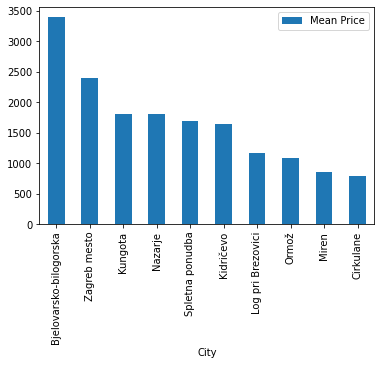

In [ ]:
most_expensive.head(10).plot.bar(y='Mean Price')

Oglejmo si oglase iz osmih "najdražjih" mest

In [ ]:
most_expensive_cities = list(data.groupby("City").mean().sort_values('Price', ascending=False).head(8).index.values)
data.loc[data['City'].isin(most_expensive_cities)].sort_values(["City", "Price"], ascending=[True, False]).set_index(["City", "Name"]).head(60)

Date  \
City                   Name                                                                            
Bjelovarsko-bilogorska Ricoh pro c 751                                     2021-10-07 10:43:26+02:00   
                       Ricoh mpc 6502                                      2021-10-07 10:43:31+02:00   
Kidričevo              MINING RIG  6XNvidia 3070 Odklenjene niso LHR       2021-11-04 13:01:25+01:00   
                       Nov Mining Rig 5xAmd rx 580 8G                      2021-11-03 12:37:16+01:00   
                       prodam                                              2021-10-28 10:02:10+02:00   
                       HP elitebook 8460p                                  2021-11-07 11:11:31+01:00   
                       Lenovo ThinkPad Yoga 11e                            2021-11-05 16:33:01+01:00   
                       Tablični Medion                                     2021-11-07 11:20:09+01:00   
                       2x8GB SO-DIMM DDR4 ram za prenosnik                 2021-11-02 15:07:29+01:00   
                       Tablični računalnik Atheros z ovitkom               2021-10-09 17:17:20+02:00   
                       Računalniška miza                                   2021-10-22 18:11:19+02:00   
Kungota                Mining rig RTX 3070 9 kom 570MH/s                   2021-11-06 15:28:47+01:00   
                       MacBook Pro 15, Retina, i7, 16 GB, 1TB+256GB, 2...  2021-11-06 15:28:25+01:00   
                       prodam gaming racunalnik                            2021-10-21 12:15:01+02:00   
                       Prenosni računalnik Acer                            2021-11-04 12:21:30+01:00   
                       ASUS Maximus VIII Impact + i7 6700K + Corsair 1...  2021-10-31 22:48:12+01:00   
                       Računalniški Procesor Intel i5 6600K (LGA 1151)     2021-11-04 15:09:31+01:00   
                       Fotografski optični bralnik HP Scanjet G3010 -b...  2021-10-21 20:57:49+02:00   
                       Procesor Intel i5 4690K (LGA 1150)                  2021-10-26 16:15:03+02:00   
                       Apple DVD drive                                     2021-11-06 15:28:30+01:00   
Log pri Brezovici      Prodam tiskalnik BN 20 ,prakticno nov               2021-10-26 15:23:57+02:00   
                       DELL XPS 15 (9560)                                  2021-10-19 20:23:15+02:00   
                       Samsung Galaxy Tab S6 Lite                          2021-10-11 11:17:35+02:00   
                       Canon iRC 2880                                      2021-10-23 19:06:06+02:00   
                       Toner Kyocera TK-590 komplet                        2021-10-21 15:42:57+02:00   
                       Računalnik HP Compaq Intel Core                     2021-10-20 19:27:39+02:00   
Nazarje                gaming računalnik                                   2021-10-09 15:15:04+02:00   
Ormož                  Mining rig 18x rx5700xt                             2021-11-02 20:28:51+01:00   
                       iMAC namizni računalnik                             2021-11-02 10:48:54+01:00   
                       PNY Quadro P2200 grafična kartica, 5GB GDDR5X (...  2021-10-24 01:35:35+02:00   
                       21 x Vintage ročne igrice igralne konzole, ročn...  2021-11-02 20:55:37+01:00   
                       Prenosnik ACER Aspire 5750G + LCD TV-Monitor Sa...  2021-11-04 17:23:50+01:00   
                       PRODAM PLAYSTATION 4                                2021-10-25 08:57:11+02:00   
                       NINTENDO GAMECUBE + 4 igre,game cube,Fifa 06,to...  2021-11-02 20:55:36+01:00   
                       SYNOLOGY DS411slim                                  2021-10-12 21:58:04+02:00   
                       ATARI 2600 VIDEO GAME, igralna konzola              2021-11-03 18:00:13+01:00   
                       4 X WORLD OF WARCRAFT IGRA                          2021-10-18 22:03:35+02:00   
                       2600 VIDEO COMPUT

Ker imajo pri povprečnih cenah prednost mesta z malo dragimi oglasi ponovimo izračun le za mesta s 100 ali več oglasi

In [ ]:
df = data.groupby("City").size()
more_than_100_cities = df[df > 100].index.to_list()

most_expensive_100 = data[data.City.isin(more_than_100_cities)].groupby("City").mean()
most_expensive_100["N_OF_ADDS"] = data.groupby("City").size() # Poglejmo si zraven še število oglasov
most_expensive_100 =  most_expensive_100.sort_values('Price', ascending=False)
most_expensive_100

,Price,N_OF_ADDS
City,,
Slovenska Bistrica,766.537118,229
Nova Gorica,531.453461,419
Slovenske Konjice,500.692771,166
Koper,429.118919,185
Celje,400.796813,251
Maribor,376.884881,1303
Ljubljana,299.512694,2836
Domžale,282.619048,273
Novo mesto,281.674242,132


<AxesSubplot:xlabel='City'>

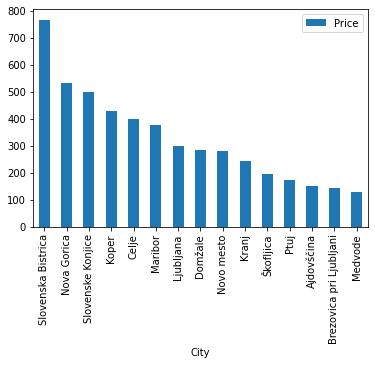

In [ ]:
most_expensive_100.plot.bar(y="Price")

Kakšna pa je zveza med ceno in časom objave? Da dobimo idejo o zvezi si najprej izrišimo graf.

<AxesSubplot:xlabel='Date', ylabel='Price'>

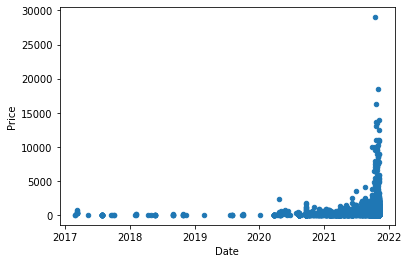

In [ ]:
data.plot.scatter('Date', 'Price')

Presenetljivo so najdražji artikli med najnovejšimi. Podrobnejša analiza najstarejših oglasov sledi v naslednjem poglavju.


### Zaključek
1. Kolikšna je cena najcenejšega in najdražjega oglasa?

    Najdražji oglas se prodaja za 28999 EUR, najcenejši pa za 23 EUR.

2. Kolikšna je povprečna cena?

    Povprečna cena oglasa je 316,25 EUR s standardno deviacijo 811,78 EUR.

3. Katera mesta imajo v povprečju najdražje oglase?

    Med mesti z najdražjim povprečjem oglasov so:
    1. ***Bjelovarsko-bilogorska*** z dvema oglasoma in povprečno ceno 3400 EUR,
    2. ***Zagreb mesto*** s petimi oglasi in povprečno ceno 2398 EUR,
    3. ***Kungota*** z devetimi oglasi in povprečno ceno 1806 EUR ter
    4. ***Nazarje*** z enim oglasom ter povprečno ceno 1800 EUR.

    Če se pri analizi omejimo le na mesta s 100 ali več oglasi so med mesti z najdražjim povprečjem oglasov:
    1. ***Slovenska Bistrica*** z 229 oglasi in povprečno ceno 766 EUR,
    2. ***Nova Gorica*** s 419 oglasi in povprečno ceno 531 EUR ter
    3. ***Slovenske Konjice*** s 166 oglasi in povprečno ceno 500 EUR.

4. Kakšna je zveza med ceno oglasa in datumom objave?

    Pri ogledu grafa cene v odvisnosti od časa smo presenetljivo ugotovili, da so najdražji oglasi tudi med najnovejšimi.

## Stari oglasi

V poglavju bomo opravili kratko analizo najstarejših oglasov na bolhi. Pojem **"Stari oglas"** bomo definirali kot oglas ki je bil objavljen pred 1.1.2020 (torej ob času analize več kot 2 leti nazaj).

### Ciljna vprašanja:
1. Kateri so najstarejši oglasi?
2. Iz katerih mest so stari oglasi?
4. Kolikšna je cena najcenejšega in najdražjega starega oglasa?
3. Kakšna je povprečna cena starih oglasov?

Poiščimo najstarejše oglase

In [ ]:
data.sort_values("Date").head(10)

,Name,Date,Price,City
9167,"Polnilec za prenosnike 19V 3,42A 4,8 1,7",2017-02-25 18:32:14+01:00,29,Ljubljana
9166,"Polnilec za prenosnike Acer 19V 3,42A 5,5 2,1",2017-02-25 19:12:17+01:00,29,Ljubljana
2478,"Omara za strežnik, server - kabinet 600x600 15...",2017-03-08 20:05:10+01:00,309,Ljubljana
2371,"Omara za strežnik, server - kabinet 600x600 22...",2017-03-08 20:06:29+01:00,331,Ljubljana
2255,"Omara za strežnik, server - kabinet 600x800 12...",2017-03-08 20:09:38+01:00,358,Ljubljana
2258,"Omara za strežnik, server - kabinet 600x900 15...",2017-03-08 20:11:47+01:00,356,Ljubljana
2222,"Omara za strežnik, server - kabinet 600x800 18...",2017-03-08 20:12:54+01:00,367,Ljubljana
1028,"Omara za strežnik, server - kabinet 600x1200 4...",2017-03-08 20:14:10+01:00,728,Ljubljana
1506,"Omara za strežnik, server - kabinet 800x800 42...",2017-03-08 20:15:23+01:00,559,Ljubljana
2370,"Omara za strežnik, server - kabinet 600x600 22...",2017-03-08 20:16:50+01:00,331,Ljubljana


Za nadaljno analizo si pripravimo tabelo starih oglasov

In [ ]:
END_DATE = datetime.datetime(2020, 1, 1, 0, 0, 0, tzinfo=dateutil.tz.tz.tzoffset(None, 0)) #2020-01-02T00:00:00+00:00
stari_oglasi = data[data.Date < END_DATE].reset_index(drop=True)
stari_oglasi.head()

,Name,Date,Price,City
0,"Omara za strežnik, server - kabinet 600x1200 4...",2017-03-08 20:14:10+01:00,728,Ljubljana
1,"Omara za strežnik, server - kabinet 800x800 42...",2017-03-08 20:15:23+01:00,559,Ljubljana
2,"Omara za strežnik, server - kabinet 600x800 18...",2017-03-08 20:12:54+01:00,367,Ljubljana
3,"Omara za strežnik, server - kabinet 600x800 12...",2017-03-08 20:09:38+01:00,358,Ljubljana
4,"Omara za strežnik, server - kabinet 600x900 15...",2017-03-08 20:11:47+01:00,356,Ljubljana


In [ ]:
print(f"Od {len(data)} vseh oglasov je {len(stari_oglasi)} starih oglasov, kar je {len(stari_oglasi)/len(data) * 100 :.2f}%")

Od 9975 vseh oglasov je 64 starih oglasov, kar je 0.64%


Iz katerih mest so in kakšne so njihove cene?

In [ ]:
df = stari_oglasi.groupby("City").mean().rename(columns={"Price" : "Mean Price"})
df["N_OF_ADDS"] = stari_oglasi.groupby("City").size() # Poglejmo si zraven še število oglasov
df = df.sort_values("N_OF_ADDS", ascending=False)

df

,Mean Price,N_OF_ADDS
City,,
Ljubljana,97.578947,57
Maribor,80.000000,3
Selnica ob Dravi,36.000000,2
Ajdovščina,50.000000,1
Kranj,75.000000,1


In [ ]:
print(f"Najdražji oglas oddan pred letom 2020 stane {stari_oglasi['Price'].max()} EUR")
print(f"Najcenejši pa {stari_oglasi['Price'].min()} EUR")
print(f"Povprečna cena vseh oglasov starejših od leta 2020 je {stari_oglasi['Price'].mean():.2f} EUR")

Najdražji oglas oddan pred letom 2020 stane 728 EUR
Najcenejši pa 23 EUR
Povprečna cena vseh oglasov starejših od leta 2020 je 93.73 EUR


### Zaključek:
1. Kateri so najstarejši oglasi?

    Glej analizo zgoraj.

2. Iz katerih mest so stari oglasi?

    Največ starih oglasov je iz ***Ljubljane***, kar je pričakovano, saj je iz ***Ljubljane*** tudi največ vseh oglasov.
4. Kolikšna je cena najstarejšega in najdražjega starega oglasa?

    Najdražji stari oglas stane 728 EUR, najcenejši pa 23 EUR.
3. Kakšna je povprečna cena starih oglasov?

    Povprečna cena oglasov starejših od leta 2020 je 93.73 EUR

## Tipi artiklov
Da bomo boljše razumeli tipi artikli se prodajajo na bolhi bomo v tem razdelku naredili funkcijo, ki nam bo iz imena določila tip artikla. To bomo naredili tako, da bomo najprej z vnaprej ustvarjeno bazo podatko klasificirali artikle za katere smo prepičani kam sodijo, nato pa uporabimo naivni bayesov klasifikator.

### Ciljna vprašanja:
1. Keteri tipi artiklov so najštevilčnejši?
2. Kateri tipi artiklov so najdražji?
3. Keteri tipi artiklov so med najstarejšimi oglasi?
4. Kateri je najbolj oglaševan artikel v posamičnem mestu?
5. Kje se v današnji ekonomiji dobi najcenejša grafična kartica?

Dodajmo najprej med naše podatke stolpec `Prediction` v katerega zapišemo tipe artiklov za katere smo prepičani kaj so.

In [ ]:
def guaranteed_type(name):
    def koren_besede(beseda):
        beseda = ''.join(znak for znak in beseda if znak.isalpha())
        if not beseda:
            return '$'
        konec = len(beseda) - 1
        if beseda[konec] in 'ds':
            konec -= 1
        while konec >= 0 and beseda[konec] in 'aeiou':
            konec -= 1
        return beseda[:konec + 1]

    guaranteed_types = {
        "Mining Rig" : {"mining", "rig", "rudarjenje", "miner", "antminer"},
        "PC" : {"pc", "macbook", "prenosnik", "računalnik", "racunalnik"},
        "Tiskalnik" : {"tiskalnik", "printer"},
        "Kartuše" : {"kartuše", "kartuse"},
        "Monitor" : {"monitor", "zaslon"},
        "Domena" : {"domena"},
        "Tipkovnica" : {"tipkovnica", "keyboard"},
        "Miška" : {"miska", "miška", "mouse"},
        "Slušalke" : {"slusalke", "slušalke", "headphones", "headset"},
        "Baterija" : {"baterija", "battery"},
        "Igralna konzola" : {"playstation", "xbox", "ps4", "gameboy", "switch", "konzola"},
        "Matična plošča" : {"matična", "maticna", "plosca", "plošča", "motherboard"},
        "Trdi disk" : {"trdi", "disk", "hard", "drive"},
        "Pomnilnik" : {"memory", "ram", "pomnilnik"},
        "Napajalnik" : {"napajalnik", "charger", "psu"},
        "Server" : {"strežnik", "streznik", "server"},
        "GPU" : {"grafična", "graficna", "kartica", "gpu", "graphics", "card"},
        "CPU" : {"procesor", "cpu", "processor"},
        "Kamera" : {"camera", "kamera"},
        "Zvočniki" : {"zvocniki", "zvočniki", "speakers"},
        "Router" : {"router"},
        "Kalkulator" : {"kalkulator", "calculator"}
    }

    words_in_name = set(map(koren_besede, name.lower().split()))
    
    intersection = {key : len(set(map(koren_besede, guaranteed_types[key])) & words_in_name) for key in guaranteed_types}
    if (most_words := sorted(intersection.items(), key=lambda item: item[1], reverse=True)[0])[1]:
        return most_words[0]
    else:
        return "Couldn't determine type"

data['Prediction'] = data.Name.apply(guaranteed_type)


Vidimo da nam je uspelo klasificirati nekoliko več kot 60% podatkov

In [ ]:
raw = data.groupby("Prediction").size().sort_values(ascending=False)
percentage = data.groupby("Prediction").size().sort_values(ascending=False) / len(data)
pd.concat([raw, percentage], axis=1).rename(columns={0 : 'Amount', 1 : 'Percentage'})

,Amount,Percentage
Prediction,,
Couldn't determine type,3784,0.379348
PC,2449,0.245514
Igralna konzola,994,0.099649
Monitor,357,0.035789
Pomnilnik,339,0.033985
Tiskalnik,299,0.029975
Trdi disk,281,0.028170
Tipkovnica,202,0.020251
GPU,194,0.019449


Poskusimo zdaj klasificirati preostale podatke z naivnim Bayesovim klasifikatorjem kot smo se učili na predavanjih. Najprej potrebujemo verjetnost napovedi glede na vse uspešne napovedi (predpostavimo da je verjetnost v neklasificiranih podatkih enaka verjetnosti v klasificiranih)

In [ ]:
type_probability = data[data.Prediction != "Couldn't determine type"].groupby('Prediction').size() / len(data[data.Prediction != "Couldn't determine type"])
type_probability.sort_values(ascending=False)


Prediction
PC                 0.395574
Igralna konzola    0.160556
Monitor            0.057664
Pomnilnik          0.054757
Tiskalnik          0.048296
Trdi disk          0.045388
Tipkovnica         0.032628
GPU                0.031336
Matična plošča     0.024390
Napajalnik         0.022775
CPU                0.021806
Miška              0.017283
Mining Rig         0.015183
Router             0.014537
Kartuše            0.011630
Slušalke           0.011145
Baterija           0.010984
Server             0.008238
Kamera             0.007592
Zvočniki           0.004684
Domena             0.001938
Kalkulator         0.001615
dtype: float64

Nato naredimo razpredelnico napovedi in besed ki se pojavijo v napovedi

In [ ]:
def f(x):
    return pd.Series(x.split())

words_in_predictions = data[data.Prediction != "Couldn't determine type"].set_index('Prediction').Name.apply(f).stack().reset_index(level='Prediction').rename(columns={0: 'Word'})
words_in_predictions.head()

,Prediction,Word
0,Mining Rig,MINING
1,Mining Rig,RIG
2,Mining Rig,-
3,Mining Rig,Rudarjenje
4,Mining Rig,-


S funkcijo crosstab preštejemo kombinacije. Iz prvega dela analize se bomo spomnili da imamo veliko "besed" ki so pravzaprav ascii znaki

In [ ]:
word_by_prediction = pd.crosstab(words_in_predictions.Word, words_in_predictions.Prediction)
word_by_prediction.head()

Prediction,Baterija,CPU,Domena,GPU,Igralna konzola,Kalkulator,Kamera,Kartuše,Matična plošča,Mining Rig,...,Napajalnik,PC,Pomnilnik,Router,Server,Slušalke,Tipkovnica,Tiskalnik,Trdi disk,Zvočniki
Word,,,,,,,,,,,,,,,,,,,,,
!,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
!!,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
!!!,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,0,0,0,0,0,0
!!!TOP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!),1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Verjetnosti dobimo tako da stolpce delimo z verjetnostjo posameznega žanra. Oglejmo si najpogostejše "besede" ki se uporabljajo v oglasih za procesorje

In [ ]:
probability_by_prediction = word_by_prediction / data[data.Prediction != "Couldn't determine type"].groupby('Prediction').size() + 0.001
probability_by_prediction.CPU.sort_values(ascending=False).head()

Word
PROCESOR    0.267667
Intel       0.252852
procesor    0.223222
Procesor    0.215815
INTEL       0.208407
Name: CPU, dtype: float64

Definirajmo funkcijo in jo preizkusimo na nekaterih, prej neklasificiranih, oglasih

In [ ]:
def determine_type(opis):
    factors = type_probability * probability_by_prediction[probability_by_prediction.index.isin(f(opis))].prod()
    factors /= max(factors)
    return factors.sort_values(ascending=False)

In [ ]:
determine_type("NVIDIA GeForce GTX 1060 6GB ( Inno3D)").head()

Prediction
GPU                1.000000e+00
Mining Rig         7.965618e-02
PC                 1.041277e-03
Pomnilnik          7.417969e-04
Igralna konzola    3.413971e-07
dtype: float64

Seveda klasifikacija ni 100% natančna

In [ ]:
determine_type("FORTNITE + GTA 5 ONLINE - RADEON HD7950").head()

Prediction
Igralna konzola    1.000000
PC                 0.409953
GPU                0.122173
Mining Rig         0.091371
Pomnilnik          0.009591
dtype: float64

In ne deluje na artiklih ki jih z našim naivnim zagotovim klasificiranjem nismo pobrali

In [ ]:
determine_type("Gaming stol LC-Power črno/rdeč").head()

Prediction
PC            1.000000
Monitor       0.136569
Miška         0.134345
Slušalke      0.134007
Tipkovnica    0.099618
dtype: float64

In [ ]:
def get_type(s):
    return determine_type(s).index[0]

data['Type'] = data.Name.apply(get_type)

Poglejmo, če je delovanje delovalo

In [ ]:
data.sample(5)

,Name,Date,Price,City,Prediction,Type
3436,Komunikacijska omara,2021-10-23 10:45:32+02:00,200,Šmartno pri Litiji,Couldn't determine type,PC
1129,SAPPHIRE PULSE Radeon RX 6600 8GB GDDR6 (11310...,2021-11-03 14:42:52+01:00,690,Ljubljana,Couldn't determine type,GPU
3327,"Namizni računalnik HP 8300 Elite SFF, i5-3470 ...",2021-09-16 16:12:52+02:00,205,Škofljica,PC,PC
266,Prodam GAMING PC z monitorjem,2021-10-17 11:19:59+02:00,1600,Slovenj Gradec,PC,PC
8925,SUPER MARIO LAND igra za Nintendo GAME BOY s k...,2021-10-18 22:37:42+02:00,30,Ljubljana,Couldn't determine type,Igralna konzola


Vidimo celo, da tako popravimo nekatere napake ki smo jih naredili pri določanju "zagotovih" tipov

In [ ]:
data[data.index == 9244]

,Name,Date,Price,City,Prediction,Type
9244,"RAM 8 GB DDR3, PC3-10600 1333 MHZ, KINGSTON, R...",2021-11-05 00:18:52+01:00,28,Ljubljana,PC,Pomnilnik


Odstranimo sedaj pomožni stolpec `Prediction` in se končno lotimo analize naših podatkov

In [ ]:
data = data.drop(columns=['Prediction'])
data.head()

,Name,Date,Price,City,Type
0,MINING RIG - Rudarjenje - Ethereum - 1.1GH/s -...,2021-10-16 12:40:29+02:00,28999,Ljubljana,Mining Rig
1,Mining rig 18x rx5700xt,2021-11-02 20:28:51+01:00,18500,Ormož,Mining Rig
2,Bitman Antminer S19 Pro 110 Th,2021-10-18 21:29:02+02:00,16300,Ljubljana,Mining Rig
3,Mining rig RTX 3070 9 kom 570MH/s,2021-11-06 15:28:47+01:00,14000,Kungota,Mining Rig
4,NOV mining Rig z 6 x Nvidia RTX3080Ti - 510 Mhs,2021-10-18 09:09:12+02:00,13590,Maribor,Mining Rig


Najštevilčnejši tipi

In [ ]:
data.groupby('Type').size().sort_values(ascending=False).head()

Type
PC                 4060
Igralna konzola    1355
Pomnilnik           791
Tiskalnik           530
Monitor             501
dtype: int64

Najdražji tipi artiklov vrednoteni z maksimalno vrednostjo in povprečjem

In [ ]:
avg_value_by_type = data[["Type", "Price"]].groupby("Type").mean().sort_values("Price", ascending=False)
avg_value_by_type.head(10)

,Price
Type,
Mining Rig,3257.534247
Domena,1543.666667
PC,389.660837
GPU,374.827128
Pomnilnik,331.817952
Server,300.317647
Baterija,248.786885
Tiskalnik,216.083019
Monitor,188.123752


In [ ]:
max_value_by_type = data[["Type", "Price"]].groupby("Type").max().sort_values("Price", ascending=False)
max_value_by_type.head(10)

,Price
Type,
Mining Rig,28999
PC,13000
Domena,10000
GPU,10000
Tiskalnik,9000
Igralna konzola,4990
Monitor,4799
Baterija,4087
Pomnilnik,3790


Tipi med starimi oglasi

In [ ]:
stari_oglasi = data[data.Date < END_DATE].reset_index(drop=True)
stari_oglasi.head()

,Name,Date,Price,City,Type
0,"Omara za strežnik, server - kabinet 600x1200 4...",2017-03-08 20:14:10+01:00,728,Ljubljana,Server
1,"Omara za strežnik, server - kabinet 800x800 42...",2017-03-08 20:15:23+01:00,559,Ljubljana,Server
2,"Omara za strežnik, server - kabinet 600x800 18...",2017-03-08 20:12:54+01:00,367,Ljubljana,Server
3,"Omara za strežnik, server - kabinet 600x800 12...",2017-03-08 20:09:38+01:00,358,Ljubljana,Server
4,"Omara za strežnik, server - kabinet 600x900 15...",2017-03-08 20:11:47+01:00,356,Ljubljana,Server


In [ ]:
stari_oglasi.groupby('Type').size().sort_values(ascending=False)

Type
PC            38
Server         9
Monitor        5
Pomnilnik      4
Baterija       3
Napajalnik     2
GPU            1
Tiskalnik      1
Trdi disk      1
dtype: int64

Najbolj oglaševani artikel v posamičnem mestu

In [ ]:
most_advertised_by_city = data.groupby("City").apply(lambda x : x.groupby("Type").size().nlargest(1).index[0]).to_frame().rename(columns={0 : "Most advertised"})
most_advertised_by_city.head(10)

,Most advertised
City,
Ajdovščina,PC
Beltinci,PC
Benedikt,Tiskalnik
Bistrica ob Sotli,Igralna konzola
Bjelovarsko-bilogorska,PC
Bled,PC
Bohinj,PC
Borovnica,PC
Bovec,Igralna konzola


In [ ]:
most_advertised_by_city[most_advertised_by_city.index == "Ljubljana"]

,Most advertised
City,
Ljubljana,PC


Kateri artikli so največkrat oglaševani v največjem številu mest?

In [ ]:
n_of_most_advertised_cities_by_article = most_advertised_by_city.reset_index().groupby("Most advertised").size().sort_values(ascending=False).head()
n_of_most_advertised_cities_by_article.head()

Most advertised
PC                 129
Igralna konzola     35
Tiskalnik            8
Pomnilnik            5
GPU                  4
dtype: int64

Za zaključek pa še, ker se vedno najbolj splača kupiti najcenejšo robo, poiščimo najcenejši oglas vsakega tipa

In [ ]:
lowest_price_by_type = data.groupby("Type").apply(lambda x : x[x.Price == x.Price.min()])
lowest_price_by_type.head(10)

Name  \
Type                                                                      
Baterija        9952  Original SAMSUNG baterija Galaxy Tab 3 10.1 T4...   
                9953  Original SAMSUNG Galaxy Tab 3 8.0 T4450E baterija   
                9956  SAMSUNG Galaxy Tab A 8.0 2016 baterija EB-BT35...   
CPU             9885  Intel CPU procesor i7-720QM 6M Cache 1.6GHz to...   
                9899                       Intel Celeron G1850 2.90 GHz   
Domena          3358                     Prodam domeno anet.si - UGODNO   
GPU             9968  grafična kartica Nvidia Geforce NVG17GA 64mb t...   
                9974  HP Compaq DX2300 Micro Tower ohišje + optični ...   
Igralna konzola 9951                    MHL-adapter Hama z HDMI izhodom   
                9958  TP-Link ojačevalec brezžičnega signala TL-WA855RE   

                                           Date  Price       City  \
Type                                                                
Baterija        9952  2021-06-05 15:41:51+02:00     23  Ljubljana   
                9953  2021-06-05 15:35:10+02:00     23  Ljubljana   
                9956  2019-09-23 12:22:47+02:00     23  Ljubljana   
CPU             9885  2021-10-24 15:16:57+02:00     24    Maribor   
                9899  2021-10-30 12:09:28+02:00     24   Poljčane   
Domena          3358  2021-11-03 23:00:38+01:00    200    Logatec   
GPU             9968  2021-10-30 11:05:50+02:00     23    Šentjur   
                9974  2021-10-20 08:44:12+02:00     23  Ljubljana   
Igralna konzola 9951  2020-10-07 00:15:36+02:00     23    Maribor   
                9958  2021-09-23 00:40:50+02:00     23    Maribor   

                                 Type  
Type                                   
Baterija        9952         Baterija  
                9953         Baterija  
                9956         Baterija  
CPU             9885              CPU  
                9899              CPU  
Domena          3358           Domena  
GPU             9968              GPU  
                9974              GPU  
Igralna konzola 9951  Igralna konzola  
                9958  Igralna konzola

Najcenejša oglasa za grafično kartico sta torej zmagoslavno

In [ ]:
lowest_price_by_type.xs('GPU', level='Type')

,Name,Date,Price,City,Type
9968,grafična kartica Nvidia Geforce NVG17GA 64mb t...,2021-10-30 11:05:50+02:00,23,Šentjur,GPU
9974,HP Compaq DX2300 Micro Tower ohišje + optični ...,2021-10-20 08:44:12+02:00,23,Ljubljana,GPU


### Zaključek
1. Keteri tipi artiklov so najštevilčnejši?

    Največ oglasov prodaja ***računalnik (PC)*** ali ***igralno konzolo***.
1. Kateri tipi artiklov so najdražji?

    Najdražji artikel tako po povprečni kot po maksimalni ceni je ***mining rig***
2. Keteri tipi artiklov so med najstarejšimi oglasi?

    Med najstarejšimi oglasi je na prvem mestu ***računalnik (PC)***, kar ni presenetljivo glede na to da je to tudi najštevilčnejši med vsemi oglasi. nekoliko bolj presenetljivo je na drugem mestu ***server***, medtem ko ***igralne konzole*** in najdražjega ***minig rig***-a ni med najstarejšimi oglasi, kar pomeni, da sta to kljub ceni zelo popularna artikla.
3. Kateri je najbolj oglaševan artikel v posamičnem mestu?

    Glej zgornjo analizo. V največ mestih je najbolj oglaševani tip ***računalnik (PC)***.
4. Kje se v današnji ekonomiji dobi najcenejša grafična kartica?

    Najcenejši grafični kartici se dobi v Ljubljani in Šentjurju za 23 EUR. Seveda je tu potrebna opomba o kvaliteti kartic ter dodatek da je pri določenih tipih (predvsem tipih s povprečno visoko ceno) najcenejši oglas posledica napake našega določevanja tipa.

# Rezultati

V analizi so bili doseženi vsi vnaprej zastavljeni cilji. Uspešno je bil ustvarjen algoritem za klasificiranje oglasov. Najbolj presenetljiv rezultat je bilo dejstvo, da so starejši artikli v povprečju cenejši od novejših kar lahko kaže na trend podražitve artiklov skozi čas, lažne cenene ponudbe, ali pa pojavo novih, dražjih artiklov v zadnjih letih.

## Potrditev in zavrženje hipotez
- **ZAVRŽENA** Najdražji artikli bodo grafične kartice
- **ZAVRŽENA** Starejši artikli bodo dražji od novejših
- **POTRJENA** Največ oglasov je na bolhi objavljenih iz Ljubljane
- **POTRJENA** Najštevilčnejši oglasi za Ljubljano so ali oglasi za grafične kartice ali oglasi za računalnike